In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


In [3]:
train_features.shape
img_cols
num_classes

10

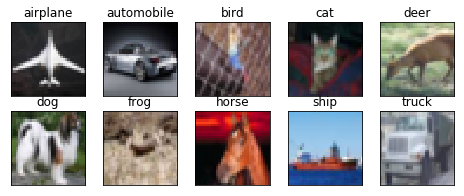

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Preprocess step

In [0]:
from keras.preprocessing.image import ImageDataGenerator
image_norm = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
#image_norm.fit(train_features)
train_iterator = image_norm.flow(train_features,train_labels,batch_size = 64)
#image_norm.fit(test_features)
test_iterator = image_norm.flow(test_features,test_labels,batch_size = 64,)

#### Loading 6a Model

**Mounting google drive and 6a model**

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/EVA/Models/6a_assign.h5')
#model.summary()

**Taking Images and observing prediction and Actual labels respetively**

In [198]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
index  = [14,35,150,1062]
input= test_features[index]
actuals = test_labels[index]
preds = model.predict(input)
pred_labels= np.argmax(preds,axis = 1)
act_labels= np.argmax(actuals,axis = 1)
class_output = []
for i in pred_labels:
    class_output.append(model.output[:, i])
print(pred_labels,act_labels)

[9 3 8 6] [9 2 8 6]


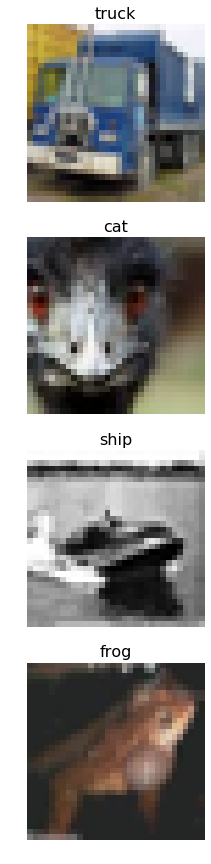

In [199]:
def plots(ims, figsize=(15,15), rows=4, interp=False,titles = None):
   f = plt.figure(figsize=figsize)
   cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
   for i in range(len(ims)):
       sp = f.add_subplot(rows, cols, i+1)
       if titles is not None:
           sp.set_title(class_names[titles[i]], fontsize=16)
       sp.axis('Off')
       plt.imshow(ims[i])
        
plots(ims = input,titles=pred_labels)

**Defining GradCam function for an Image**

In [0]:
def get_gradcam(img_index,layer_name,class_output,input_image):
  last_conv_layer = model.get_layer(layer_name)
  grads = K.gradients(class_output[img_index], last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([input])
  for i in range(192):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  from google.colab.patches import cv2_imshow
  import cv2
  img = input[img_index]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  heatmap = heatmap.astype(np.float32)
  superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.2, 0)
  final_a = np.hstack((input_image[img_index],superimposed_img))
  return final_a
  


**Plotting actual and gradcam Image**

W0630 13:23:47.883104 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0630 13:23:47.905901 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0630 13:23:47.930761 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0630 13:23:47.949708 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


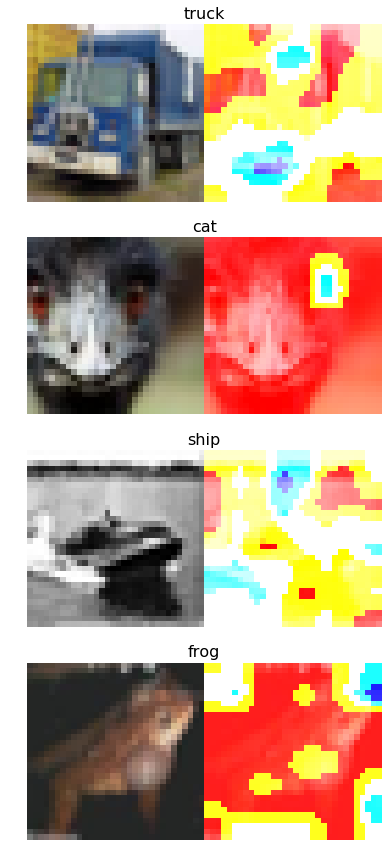

In [201]:
grad_cam_list = []
for img_index in range(len(input)):
  grad_cam_list.append(get_gradcam(img_index,'conv2d_12',class_output,input))
plots(ims = grad_cam_list,titles=pred_labels)


Defining Cutout Implementation
---



In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser



**Mounting old model and training it with Cutout preprocessing**

In [0]:
from keras.models import load_model
model2 = load_model('/content/drive/My Drive/EVA/Models/6a_assign.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=90)`
  if sys.path[0] == '':


Epoch 1/90
390/390 [==============================] - 12s 30ms/step - loss: 0.4855 - acc: 0.8394 - val_loss: 0.6063 - val_acc: 0.8232
Epoch 2/90
390/390 [==============================] - 10s 27ms/step - loss: 0.4176 - acc: 0.8539 - val_loss: 0.5535 - val_acc: 0.8315
Epoch 3/90
390/390 [==============================] - 10s 27ms/step - loss: 0.4002 - acc: 0.8582 - val_loss: 0.5524 - val_acc: 0.8320
Epoch 4/90
390/390 [==============================] - 10s 26ms/step - loss: 0.4015 - acc: 0.8581 - val_loss: 0.5509 - val_acc: 0.8328
Epoch 5/90
390/390 [==============================] - 10s 26ms/step - loss: 0.3921 - acc: 0.8593 - val_loss: 0.5539 - val_acc: 0.8374
Epoch 6/90
390/390 [==============================] - 10s 27ms/step - loss: 0.3885 - acc: 0.8615 - val_loss: 0.5593 - val_acc: 0.8353
Epoch 7/90
390/390 [==============================] - 10s 27ms/step - loss: 0.3849 - acc: 0.8607 - val_loss: 0.5603 - val_acc: 0.8325
Epoch 8/90
390/390 [==============================] - 10s 27ms

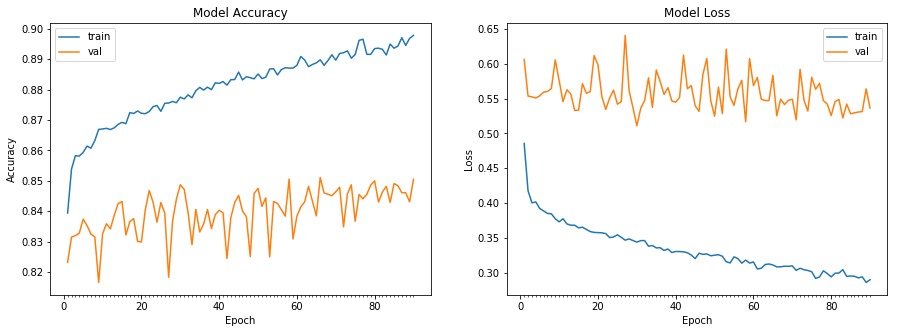

Accuracy on test data is: 85.05


In [47]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model2.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 90, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model2))

In [0]:
model2.save('/content/drive/My Drive/EVA/Models/9a_assign_cutout.h5')

In [202]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/EVA/Models/9a_assign_cutout.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 48)        0         
__________

In [203]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
index  = [14,35,150,1062]
input= test_features[index]
actuals = test_labels[index]
preds = model.predict(input)
pred_labels= np.argmax(preds,axis = 1)
act_labels= np.argmax(actuals,axis = 1)
class_output = []
for i in pred_labels:
    class_output.append(model.output[:, i])
print(pred_labels,act_labels)

[9 3 8 6] [9 2 8 6]


**Plotiing Original imge, gradcam for original 6a model, Gradcam for model with cutout implementation respectively**

W0630 13:24:32.419237 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0630 13:24:32.440266 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0630 13:24:32.455731 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0630 13:24:32.473722 140289680369536 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


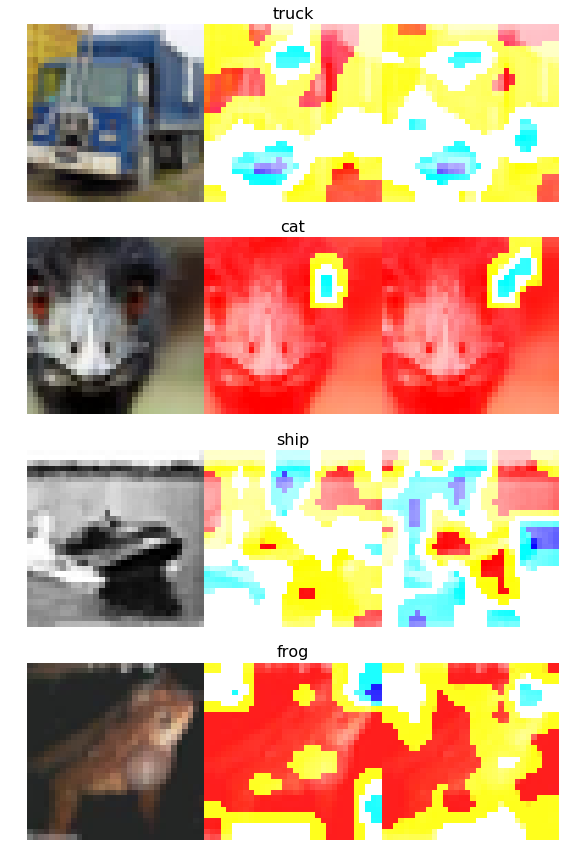

In [204]:
grad_cam_list_new = []
for img_index in range(len(input)):
  grad_cam_list_new.append(get_gradcam(img_index,'conv2d_12',class_output,grad_cam_list))
plots(ims = grad_cam_list_new,titles=pred_labels)